# Accidentes Canada

En este problema de Machine Learning nuestro objetivo será ser capaces de detectar ciertos patrones en los accidentes, como rango de edad donde es más probable que sucedan, los meses con más accidentes, etc. Tras esto trataremos de buscar un modelo y estudiar cuáles son las variables más importantes a la hora de que haya fallecidos en un accidente de tráfico. Todas las explicaciones de qué significa cada código se encuentran en kaggle, no vamos a explicar todas ya que son muy extensas, pero si explicaremos las conclusiones y qué significan los que veamos más relevantes en nuestro análisis.

Lo primero que haremos será preparar el conjunto de datos para que podamos abrirlo más rápido y de manera más sencilla, ya que hay más de 5 millones de registros, convertiremos el archivo de .csv a .parquet (menor coste computacional). Para esto utilizaremos el siguiente código python(puesto aquí ya que una vez ejecutado  es suficiente).
```python
import pandas as pd
df = pd.read_csv('Accidentes_Canada.csv')
df.drop(['P_ID'], axis = 1, inplace = True)
columns = df.columns
columns = list(columns)
columns.remove('P_SEX')
for var in columns:
    # Intentar convertir la columna a tipo entero
    try:
        df[var] = df[var].astype(int)
    except ValueError:
        # Si ocurre un ValueError, reemplazar los valores no válidos con NaN o un valor específico
        df[var] = pd.to_numeric(df[var], errors='coerce', downcast = 'integer')
```
En general, todas las variables poseen un código y valores del tipo `U`, `X`, `N` y `Q`. Los valores de tipo `U` son aquellos con origen desconocido, los valores de tipo `X` son aquellos datos que el registro no quiso/pudo proporcionar, los valores de tipo `N` son aquellos en el que el tipo de dato no es aplicable, como por ejemplo un para un peatón, por último los valores de tipo `Q` son aquellos en los que lo ocurrido es diferente a cualquiera de un hecho acontecido en los códigos de las variables. Como observamos, decidimos tratar todos estos tipos como nulos ya que desconocemos cuál es el verdadero motivo aunque tengan orígenes diferentes. Como la información proporcionada es mediante códigos(de valor numérico), el archivo .parquet contendrá estos códigos en valor numérico y si hay que realizar transformaciones lo haremos sobre valores numéricos(conservando queel `01` significa lo mismo que el `1`). 

Con todos estos pasos explicados comencemos con el análisis exploratorio.

# 0. Importación y lectura

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_parquet('Accidentes_Canada.parquet')

# 1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860405 entries, 0 to 5860404
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   C_YEAR  int32  
 1   C_MNTH  float64
 2   C_WDAY  float64
 3   C_HOUR  float64
 4   C_SEV   int32  
 5   C_VEHS  float64
 6   C_CONF  float64
 7   C_RCFG  float64
 8   C_WTHR  float64
 9   C_RSUR  float64
 10  C_RALN  float64
 11  C_TRAF  float64
 12  V_ID    float64
 13  V_TYPE  float64
 14  V_YEAR  float64
 15  P_SEX   object 
 16  P_AGE   float64
 17  P_PSN   float64
 18  P_ISEV  float64
 19  P_SAFE  float64
 20  P_USER  float64
dtypes: float64(18), int32(2), object(1)
memory usage: 894.2+ MB


Como nuestro objetivo final se basa en elaborar un modelo para determinar si hubo fallecidos o no, la variable que recoge dicha informacion es C_SEV donde `1` indica que hubo fallecidos y `2` que no hubo fallecidos.

In [4]:
df.C_SEV.value_counts()

C_SEV
2    5761772
1      98633
Name: count, dtype: int64

Se trata de un problema muy desbalanceado, donde la proporción de fallecidos es alrededor de un 1.7%.

In [5]:
df['C_SEV'] = df['C_SEV'].replace({2:0}) # Reemplazamos 2 por 0
df['P_SEX'] = df['P_SEX'].map({'M':1,'F':0}) # Reemplazamos M(Male) por 1 y F(Female) por 0

In [6]:
df['sexo']= pd.to_numeric(df.P_SEX, errors='coerce', downcast='integer')
df.drop(['P_SEX'], axis = 1, inplace = True)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
C_YEAR,5860405.0,2005.999403,4.569887,1999.0,2002.0,2006.0,2010.0,2014.0
C_MNTH,5860020.0,6.714063,3.433410,1.0,4.0,7.0,10.0,12.0
C_WDAY,5859082.0,4.010584,1.932659,1.0,2.0,4.0,6.0,7.0
C_HOUR,5800996.0,13.698790,5.197796,0.0,10.0,14.0,17.0,23.0
C_SEV,5860405.0,0.016830,0.128636,0.0,0.0,0.0,0.0,1.0
C_VEHS,5859861.0,2.045766,1.268792,1.0,2.0,2.0,2.0,77.0
C_CONF,5396406.0,22.698627,11.559058,1.0,21.0,21.0,35.0,41.0
C_RCFG,5211459.0,1.717369,0.780458,1.0,1.0,2.0,2.0,10.0
C_WTHR,5757417.0,1.605963,1.115974,1.0,1.0,1.0,2.0,7.0
C_RSUR,5611737.0,1.582910,1.110135,1.0,1.0,1.0,2.0,9.0


## 1.1 Tratamiento de missing

In [8]:
import missingno as msno

def missing_col(dataframe: pd.DataFrame = df) -> dict:

  ''' 
  Observa los valores missing por columna(variables).
  Input: DataFrame
  Output: Dictionary
'''

  dic = {}
  for col in dataframe.columns:
    if dataframe[col].isna().sum() != 0:
      dic[col] = dataframe[col].isna().sum()
  dic = dict(sorted(dic.items(), key = lambda item: item[1], reverse = True))
  return dic

def p_col(missing: dict, dataframe: pd.DataFrame = df) -> dict:

  '''
  Insertas los valores missing por columna y devuelve sus porcentajes.
  Input: Dictionary(missing) y DataFrame
  Output: Dictionary
'''

  pmis = dict(zip(missing.keys(), map(lambda x: 100*x/len(dataframe), missing.values())))
  return pmis

def key_to_list(dic: dict) -> list:

  ''' 
  Inserta un diccionario y devuelve una lista con sus claves.
'''

  return list(dic.keys())

def mis_map(lst: list, dataframe: pd.DataFrame = df):

  '''
  Inserta la lista de missing y el dataframe, devuelve heatmap con sus valores missing.
  Rojo -> Missing
  Azul -> No Missing
'''

  return sns.heatmap(dataframe[lst].isna(), cmap = 'coolwarm')

def missing_row(dataframe: pd.DataFrame = df, threshold: float = .3) -> list:

  '''
  Coge un dataframe y un umbral para determinar que observaciones tienen tanta cantidad de missing.
  Devuelve una lista con el número de las observaciones.
'''

  indexes = []

  suma = dataframe.isna().sum(axis = 1).map(lambda x: x/dataframe.shape[1])
  for cnt, idx in suma.items():
    if idx > threshold:
      indexes.append(cnt)
  return indexes
  
def problematics(rows: list, dataframe: pd.DataFrame = df) -> pd.DataFrame:

  '''
  Insertas una lista con las observaciones(filas) con varios missing y devuelve un dataframe con dichas observaciones.
'''

  return dataframe.iloc[rows]

def  missing_cor(dataframe: pd.DataFrame = df):

  '''
  Devuelve la correlación entre los valores missing de un dataframe de forma gráfica.
'''

  return msno.heatmap(dataframe)

In [9]:
len(missing_row(threshold = .2))

225878

Para facilitar el cálculo dado que disponemos de muchos datos (y un equipo computacional limitado), vamos a eliminar todas aquellas observaciones que posean más de un 20% de missing, aunque cabe destacar que en la vida real habría que tratar todo el conjunto de datos sin ignorar los missing por porcentaje (la técnica que seguiríamos sería la misma pero con más datos). 

In [10]:
df.drop(missing_row(threshold = .2), inplace = True)

Ahora vamos a realizar el mismo criterio pero con las variables, para eliminar la mayor cantidad de datos posibles

In [11]:
p_col(missing_col())

{'P_SAFE': 18.493584288441603,
 'C_RCFG': 9.948820903688988,
 'V_YEAR': 8.579176211241867,
 'C_CONF': 7.2762451932522465,
 'C_RALN': 6.873726933955592,
 'P_AGE': 4.387005333366936,
 'P_ISEV': 4.345688644317438,
 'C_TRAF': 4.152611212973157,
 'V_TYPE': 3.9368521971764445,
 'C_RSUR': 3.5150599154108235,
 'sexo': 2.1334710083029154,
 'P_USER': 1.2745524158460861,
 'C_WTHR': 0.9805969516163469,
 'C_HOUR': 0.9406645846226311,
 'P_PSN': 0.26019930333105157,
 'C_WDAY': 0.01536952436291458,
 'C_VEHS': 0.0026266623622533,
 'C_MNTH': 0.001668285554404123,
 'V_ID': 0.0008341427772020615}

En este caso, como no tenemos ninguna variable que supere el 20% de valores missing, vamos a continuar con nuestro análisis sin eliminar variables (por el momento). 

Ahora vamos a proceder a realizar un análisis más en profundidad de los propios datos y lo que suponen de cara a los accidentes de tráfico. Lo primero a realizar será discretizar ciertas variables como puede ser la hora o las edades, a pesar de poder tratarlas como "continuas", para facilitar el coste computacional las dividiremos en rangos.

Por este [enlace](https://es.travelplansinmomhands.com/article/what_are_typical_canadian_meal_times) sacamos en conclusión que hay 3 comidas en Canadá, la primera el desayuno de 7:00 a 9:00, posteriormente el almuerzo de 12:00 a 14:00 y finalmente la cena entre las 17:00 y 18:00. Nos basaremos en estos horarios para discretizar las horas de forma genérica y observar en qué momento es más común un accidente de tráfico.

In [12]:
bins_age = [-1, 18, 25, 40, 65, np.inf]
bins_hour = [-1, 6, 9, 11, 14, 18, np.inf]
bins_vehs = [0, 1, 2, np.inf] # Más de dos vehículos lo discretizamos como uno solo, ya que no suele ser común accidentes de 
#múltiples vehículos (en el .describe() se observa)
bins_v_id = [0, 98, np.inf] # 99 Indica peatón
bins_v_year = [0, 1970, 1980, 1990, 2000, 2010, np.inf]

# Aplicar la discretización usando cut
df['grupo_edad'] = pd.cut(df['P_AGE'], bins_age, labels = [0, 1, 2, 3, 4])
df['horario'] = pd.cut(df['C_HOUR'], bins_hour, labels = [0, 1, 2, 3, 4, 5])
df['n_vehiculos'] = pd.cut(df['C_VEHS'], bins_vehs,  labels = [1, 2, 3])
df['v_id'] = pd.cut(df['V_ID'], bins_v_id, labels = [0, 1]) 
df['v_year'] = pd.cut(df['V_YEAR'], bins_v_year, labels = [0, 1, 2, 3, 4, 5])

df.drop(['P_AGE', 'C_HOUR', 'C_VEHS', 'V_ID', 'V_YEAR'], axis = 1, inplace = True)

df['grupo_edad']= pd.to_numeric(df.grupo_edad, errors='coerce', downcast='integer')
df['horario']= pd.to_numeric(df.horario, errors='coerce', downcast='integer')
df['n_vehiculos']= pd.to_numeric(df.n_vehiculos, errors='coerce', downcast='integer')
df['v_id']= pd.to_numeric(df.v_id, errors='coerce', downcast='integer')
df['v_year'] = pd.to_numeric(df.v_year, errors='coerce', downcast='integer')

Para el resto de variables no discretizamos de momento ya que no hace falta. Cabe destacar que para nuestro análisis no utilizaremos la variable `P_ISEV` ya que se trata de una versión con más información que `C_SEV`, en la cual indica si hubo muertos, heridos o ninguna de las anteriores, no tendría sentido utilizar una variable con más información que la que queremos predecir (además de que en la vida real no podríamos utilizar esta variable ya que llegaría al mismo tiempo que `C_SEV`). Por lo tanto, ahora prescindiremos de ella pero la utilizaremos en la fase de modelado para predecirla ya que nos otorga más información y el estudio de los factores diferenciales entre un no herido, herido y un fallecido.

In [13]:
df.fillna(100, inplace=True)

La imputación de los missing la podríamos realizar por técnicas multivariables vistas en la asignatura o por técnicas más clasicas como la moda pero, en este caso nos vamos a decantar por una creación de una nueva categoría, que será escogida por el número 100 y que indicará todos aquellos casos en los que no está registrado a qué categoría pertenece, donde también podremos ver si existe una relación entre los casos no registrados y los fallecidos.

## 1.2 Visualización de los datos

Una vez realizados estos cambios pasaremos a la visualización e interpretación de los datos.

In [14]:
def dsc_cont_vars(dataframe: pd.DataFrame = df, threshold: int = 50):
  '''
  Data un dataframe, decidimos cuales son discretas y continuas en base a la cantidad de valores únicos que tienen.
  ¡OJO! esta función solo es válida para datos numéricos.
'''
  dates = [col for col in dataframe.columns if dataframe[col].dtype != 'float' and dataframe[col].dtype != 'int']
  dsc = [col for col in dataframe.columns if len(dataframe[col].unique()) <= threshold and  col not in dates]
  cnt = [col for col in dataframe.columns if len(dataframe[col].unique()) > threshold and col not in dates]
  return dsc, cnt, dates

dsc_var, cnt_var, date_var = dsc_cont_vars()

def cut(alpha: float = .05, dataframe: pd.DataFrame = df):
  '''
  alpha: Selecciona el corte que se quiere realizar por arriba y por abajo de los datos.
  dataframe: Sobre que conjunto de datos quieres realizarlo.
'''
  L, U = int(len(dataframe)*alpha), int(len(dataframe)*(1-alpha)) 
  return L, U 

In [15]:
dsc_var.remove('C_SEV')
dsc_var.remove('P_ISEV')

In [16]:
def plot_things(dataframe: pd.DataFrame = df, target = 'C_SEV'):
  if target == 'C_SEV':
    color = ['green', 'red']
    label = ['No fallecido', 'Fallecido']
  else:
    print(f'No es un target válido {target}')
  for col in dsc_var:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 4))
    grouped_df = dataframe.groupby([col, target]).size().reset_index(name='COUNT')

    # Utilizar pivot_table para reorganizar el DataFrame
    pivot_df = pd.pivot_table(grouped_df, values='COUNT', index=col, columns=target, fill_value=0)

    pivot_df['Total'] = pivot_df.sum(axis=1)
    for elem in range(len(dataframe[target].unique())):
      pivot_df[f'Percentage_{elem}'] = (pivot_df.iloc[:, elem] / pivot_df['Total']) * 100
      if elem == 0:
        sns.barplot(data=pivot_df, x=pivot_df.index, y=f'Percentage_{elem}', color=color[elem], label= label[elem], ax = axes[0])
        sns.barplot(data = pivot_df, x = pivot_df.index, y = 'Total', ax = axes[1]);
      else:
        sns.barplot(data=pivot_df, x=pivot_df.index, y=f'Percentage_{elem}', color=color[elem],
                 label= label[elem], ax = axes[0], bottom = pivot_df[f'Percentage_{elem-1}'])
        sns.barplot(data = pivot_df, x = pivot_df.index, y = 'Total', ax = axes[1]);

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title(f'Porcentaje de fallecidos respecto a {col} y {target}')
    axes[1].set_title(f'Accidentes producidos en {col}')
    axes[0].legend(loc ='lower right')

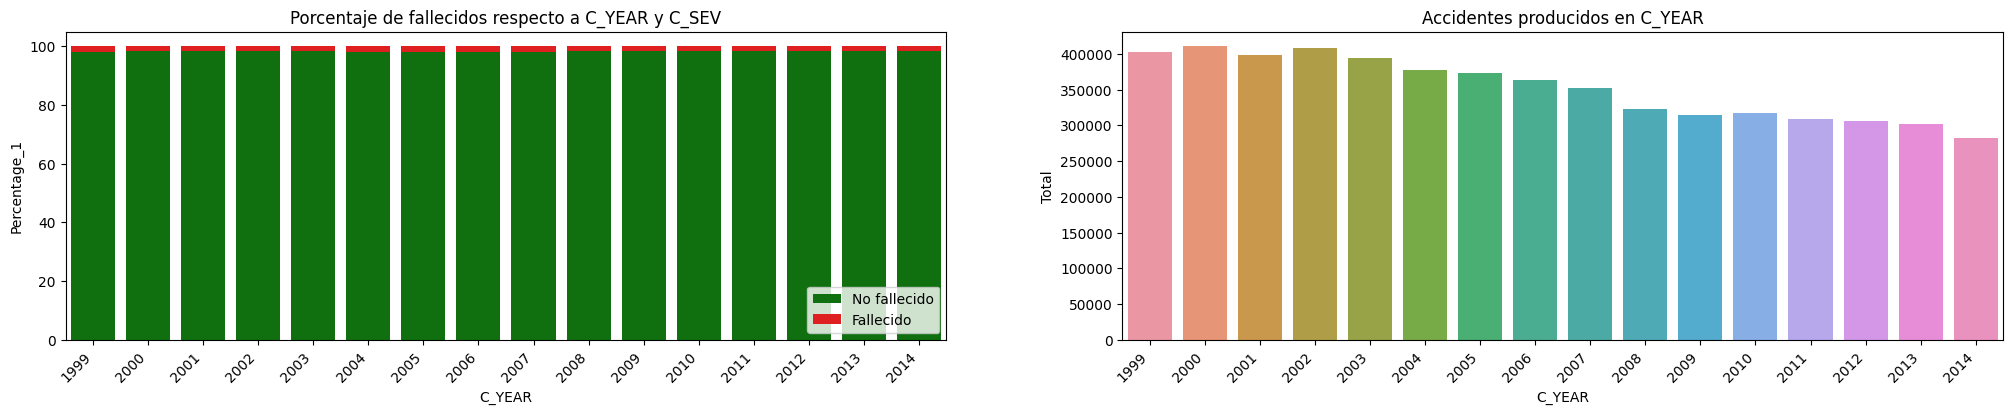

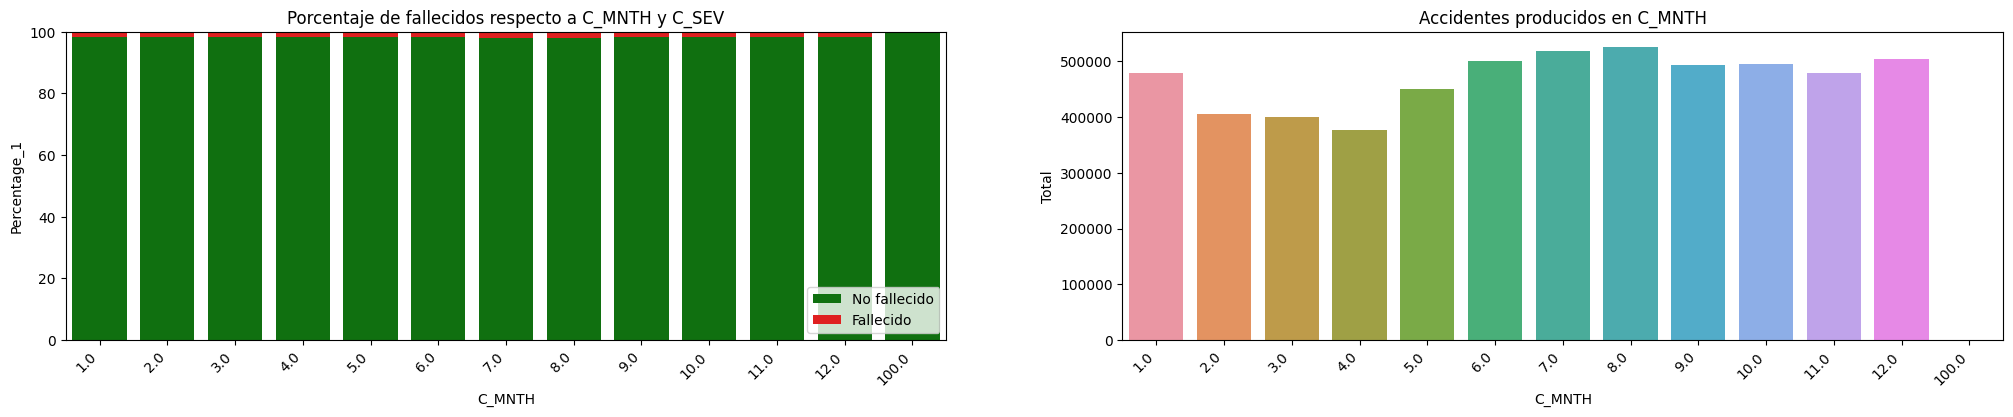

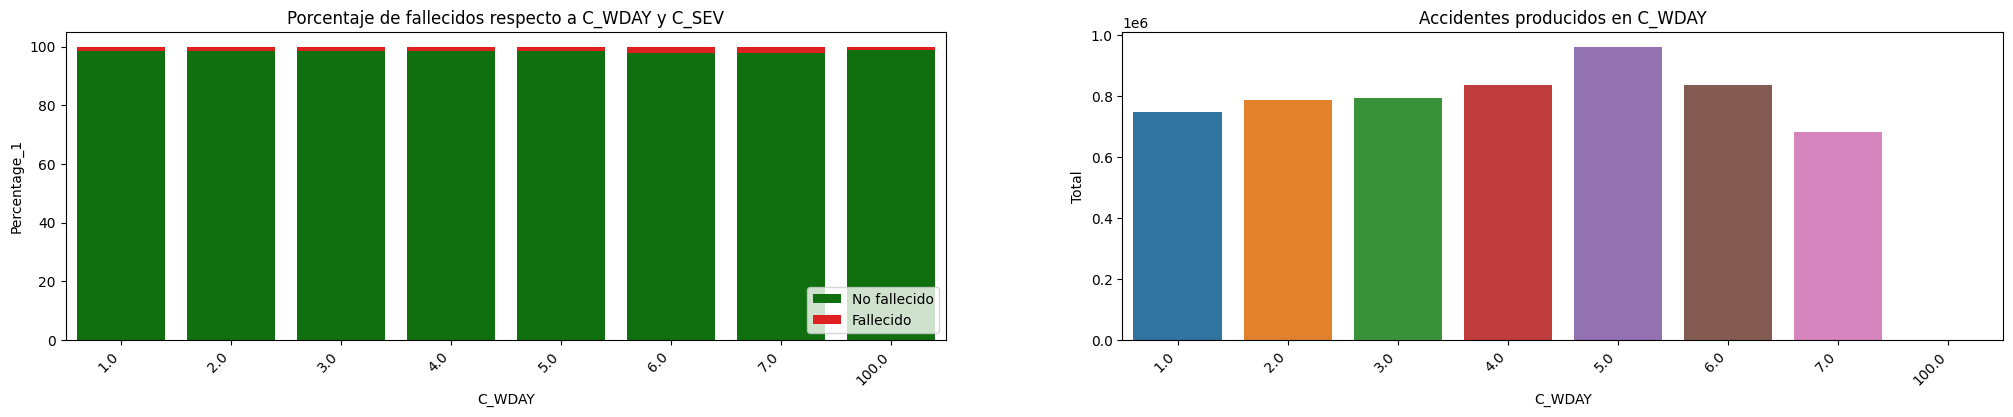

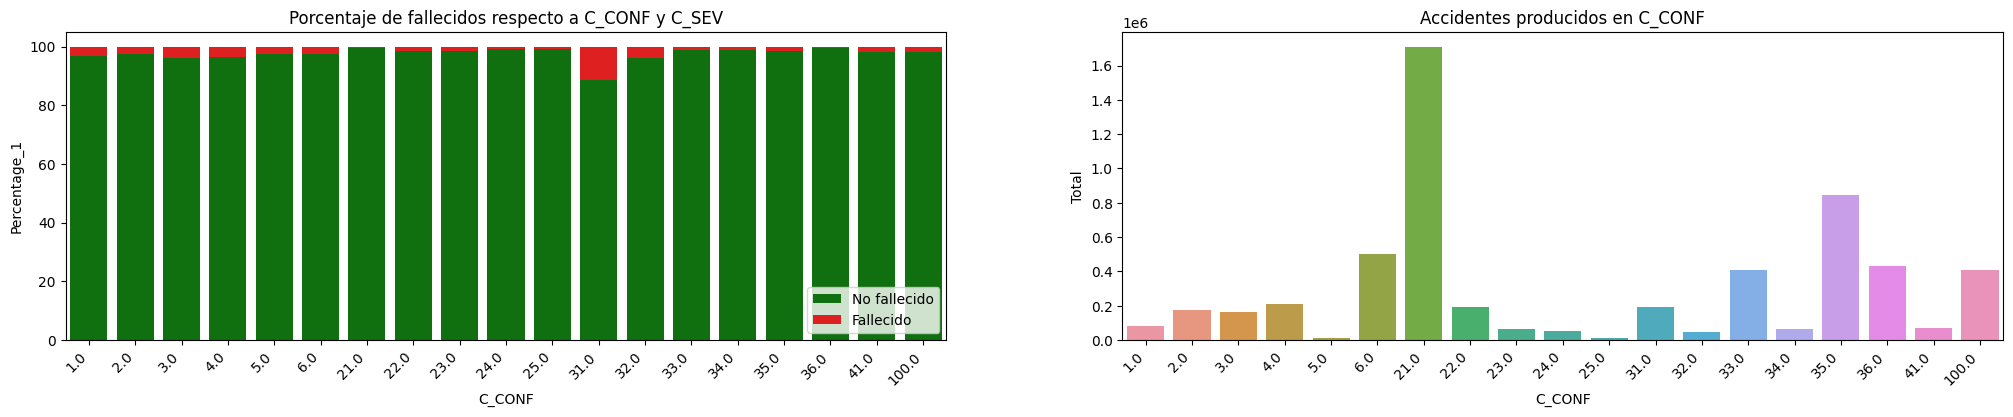

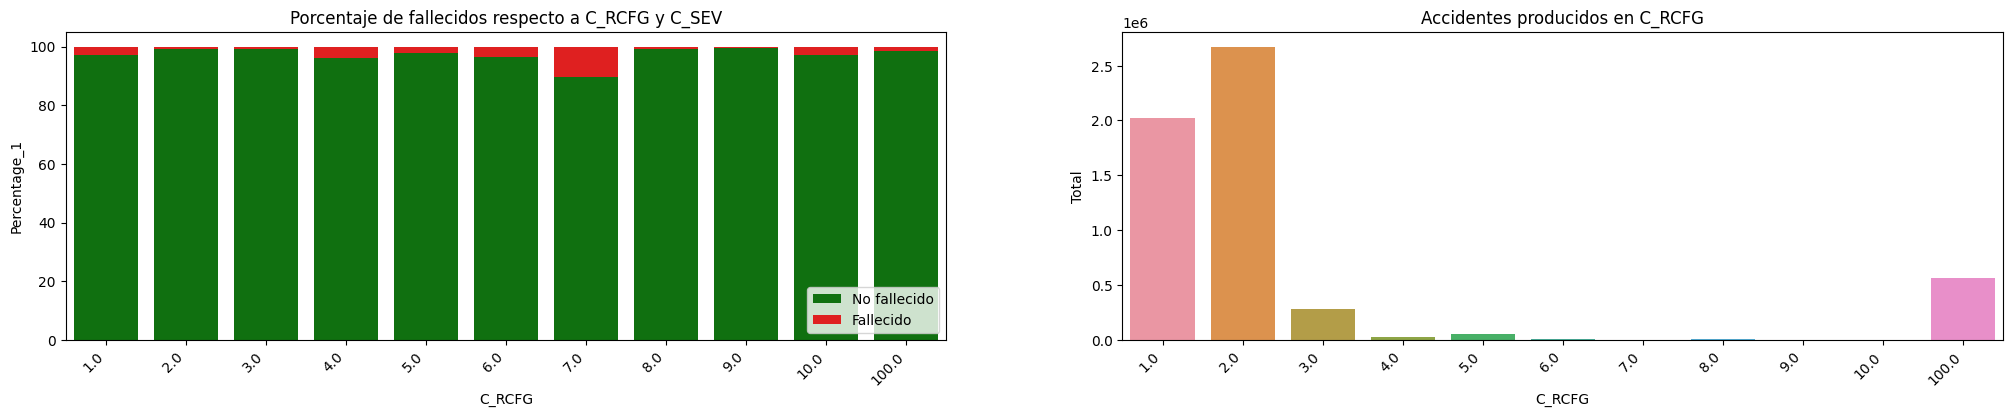

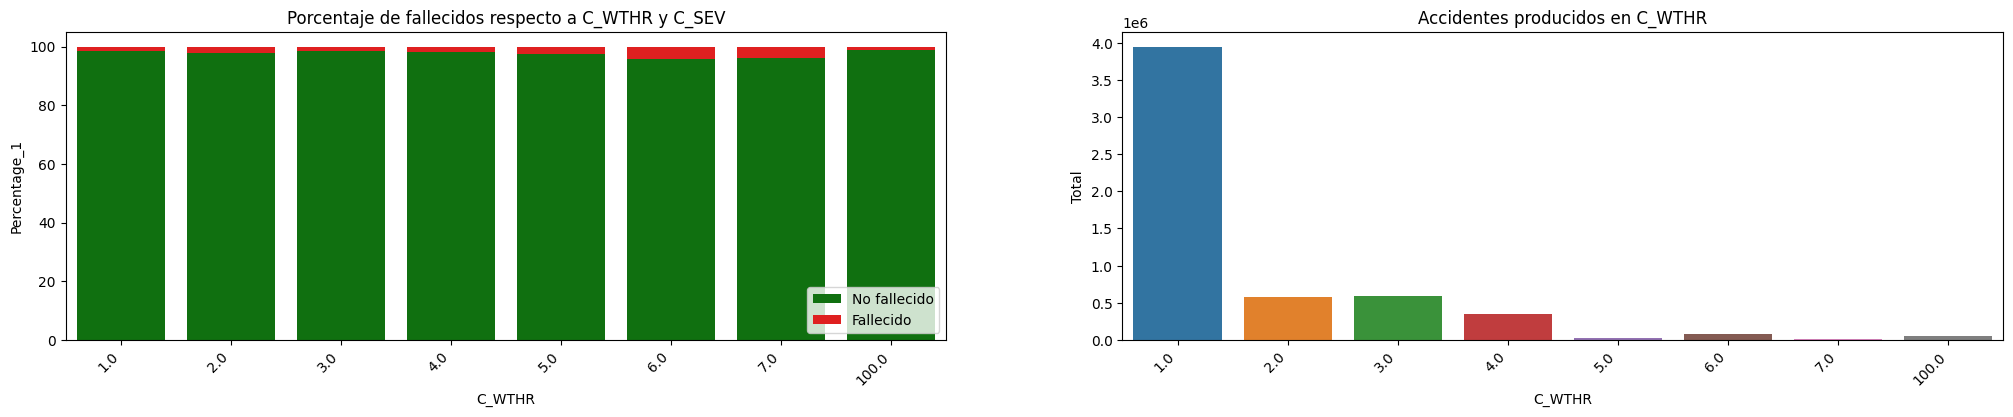

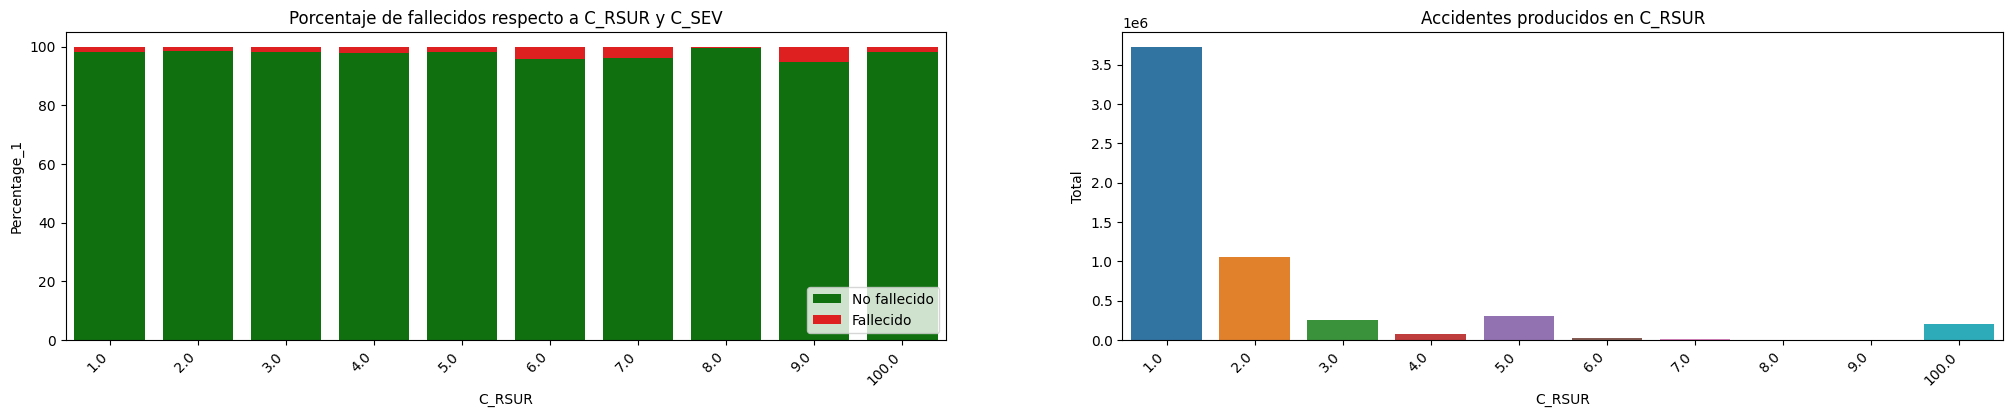

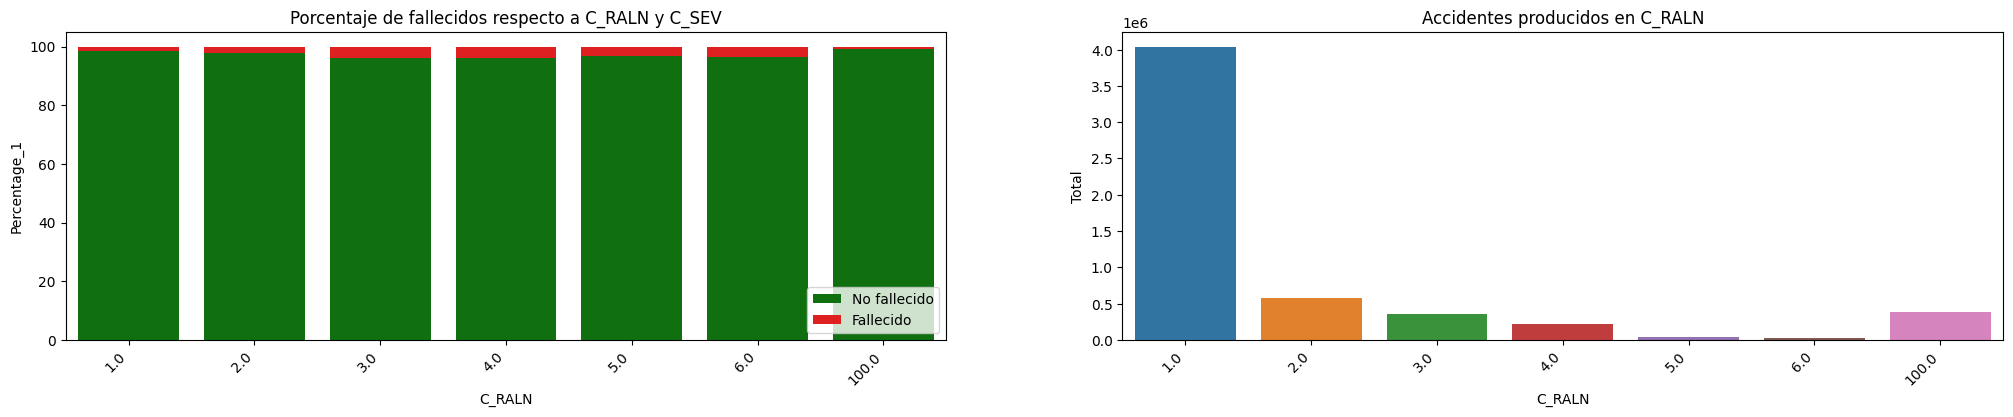

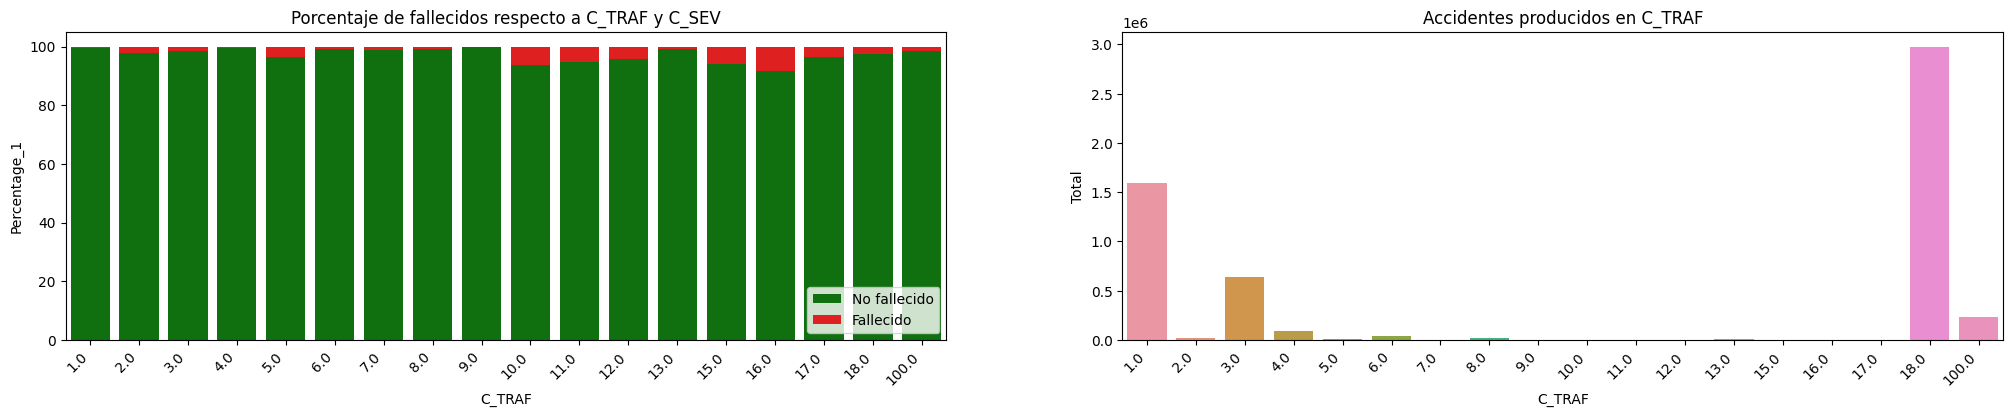

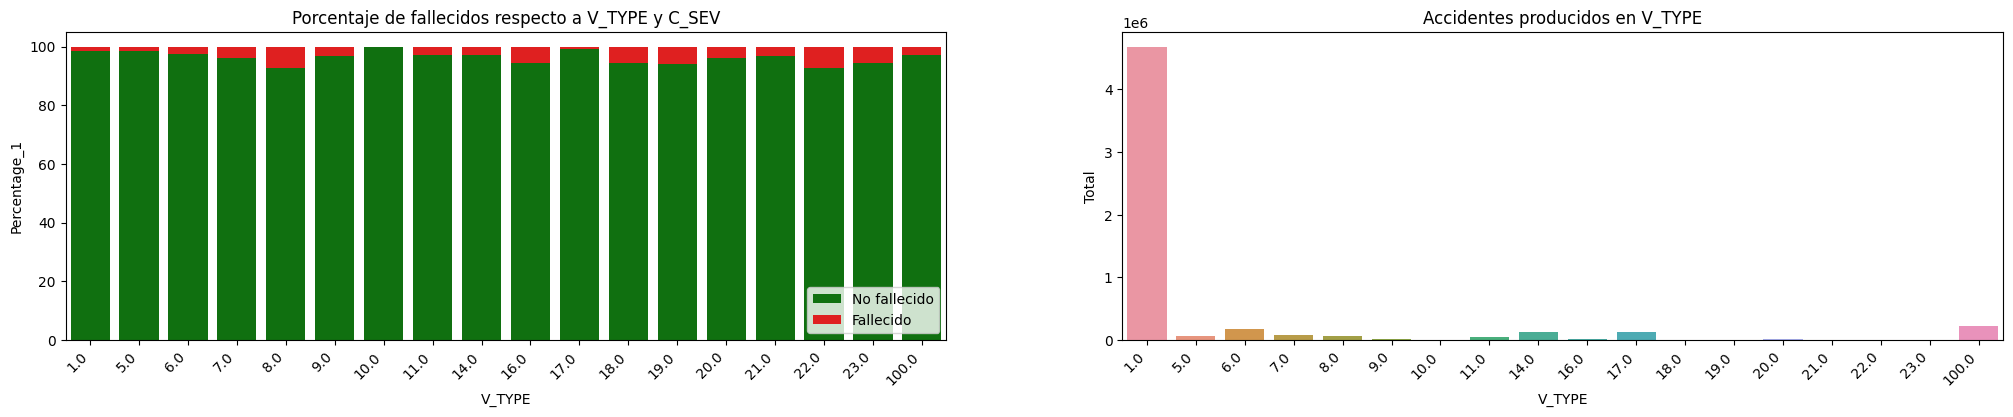

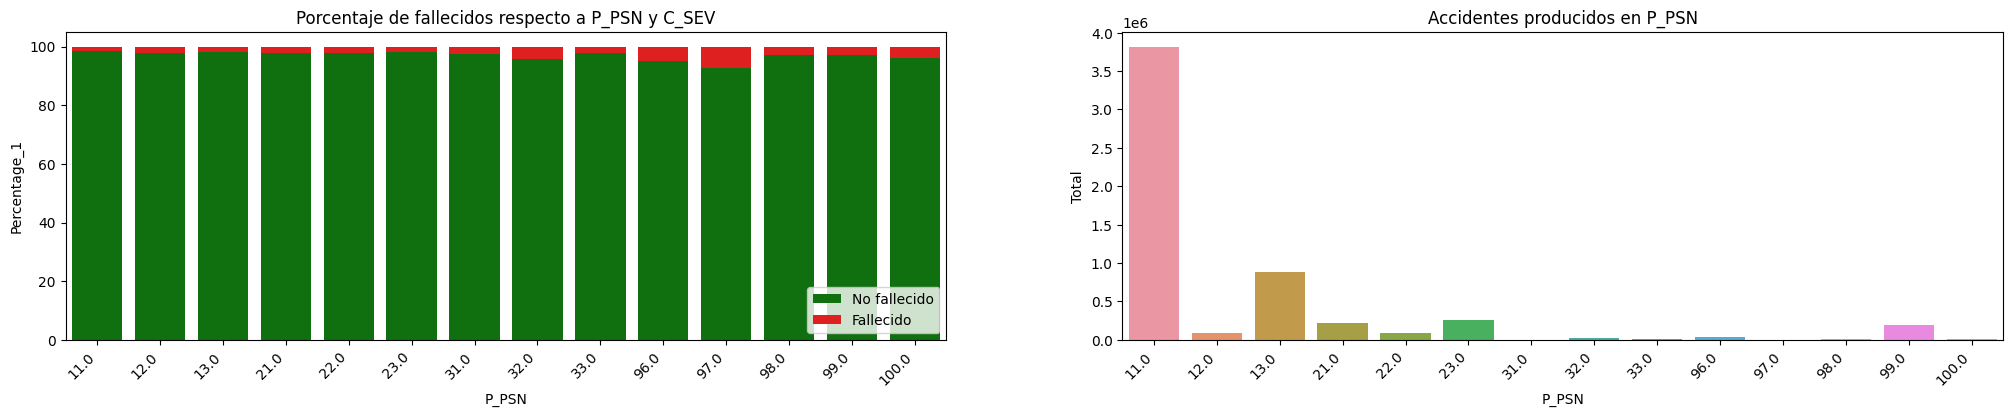

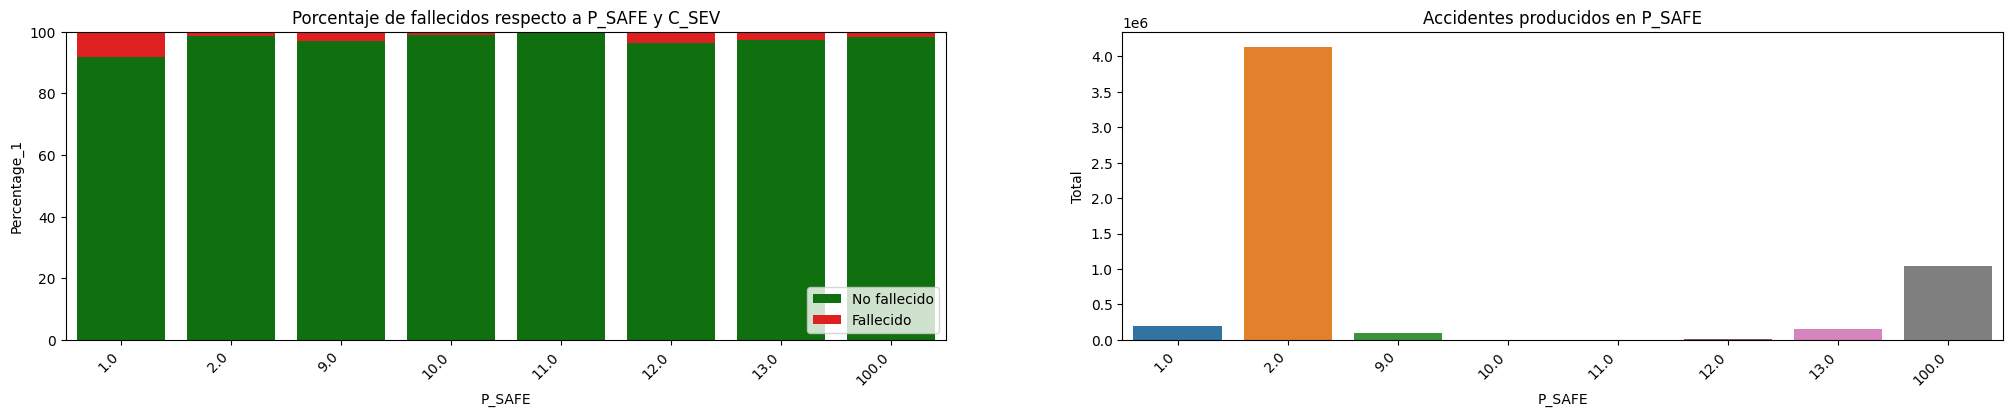

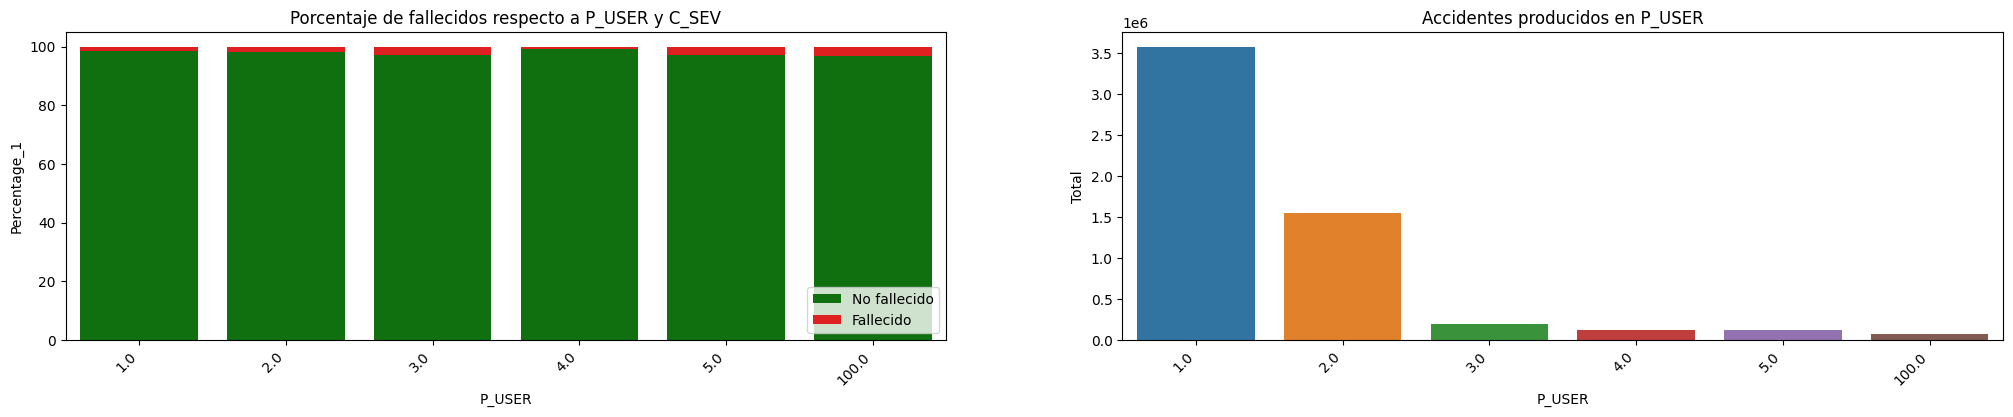

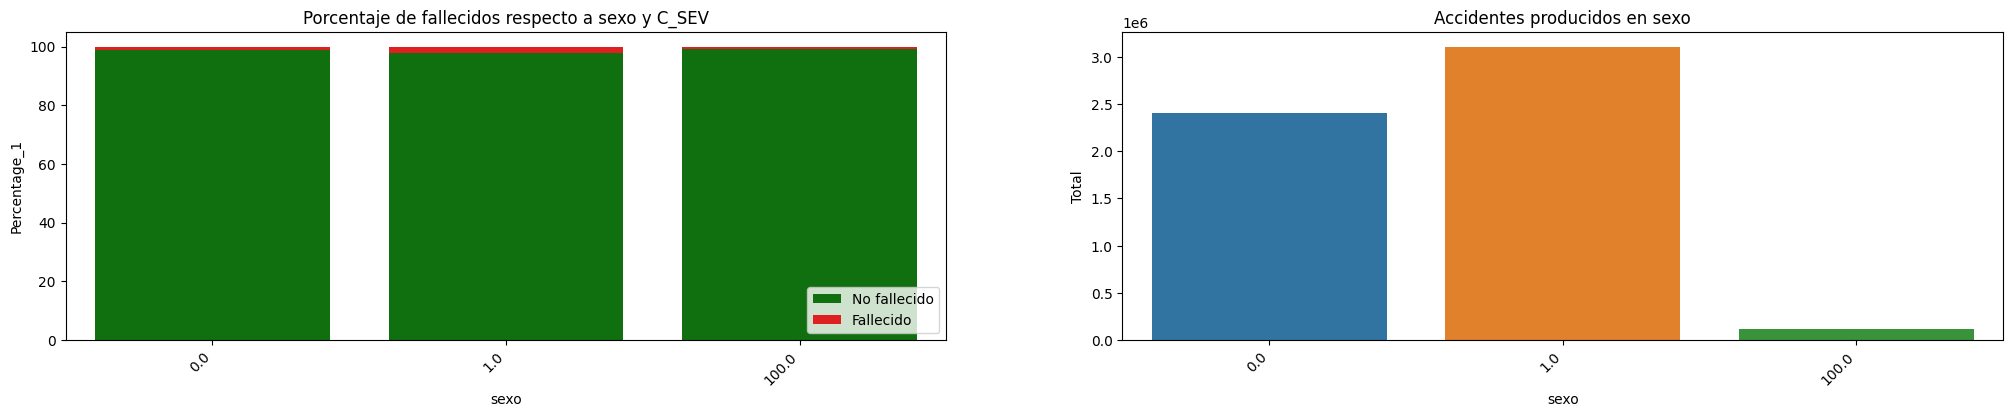

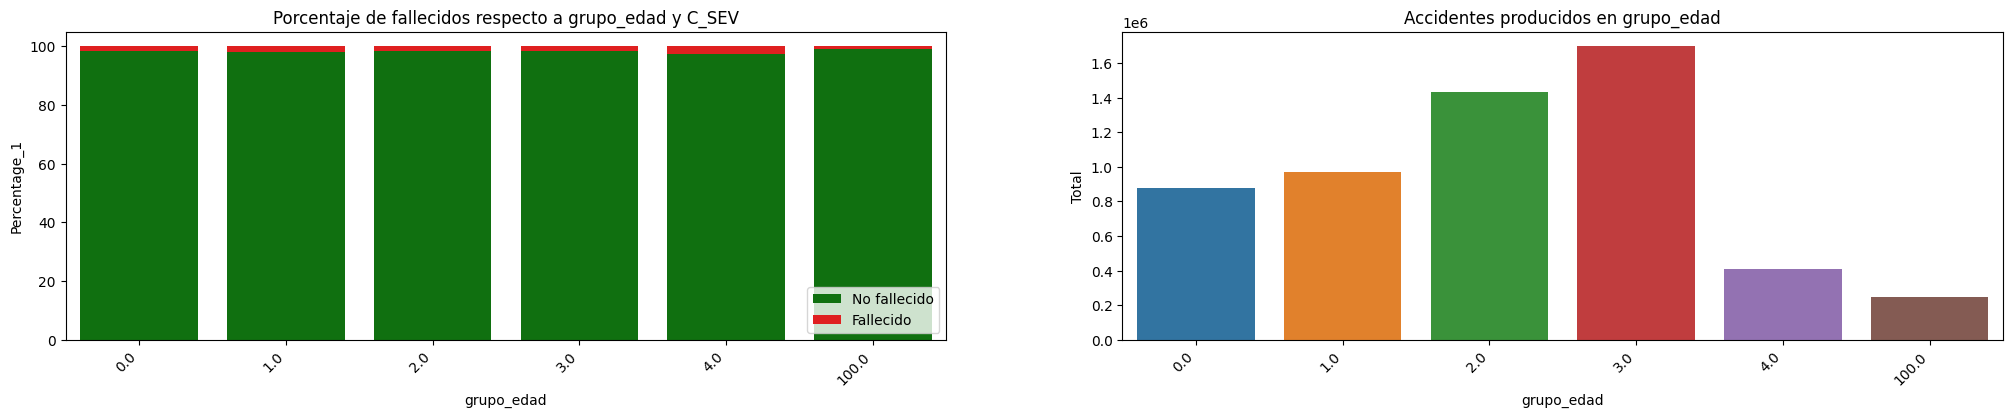

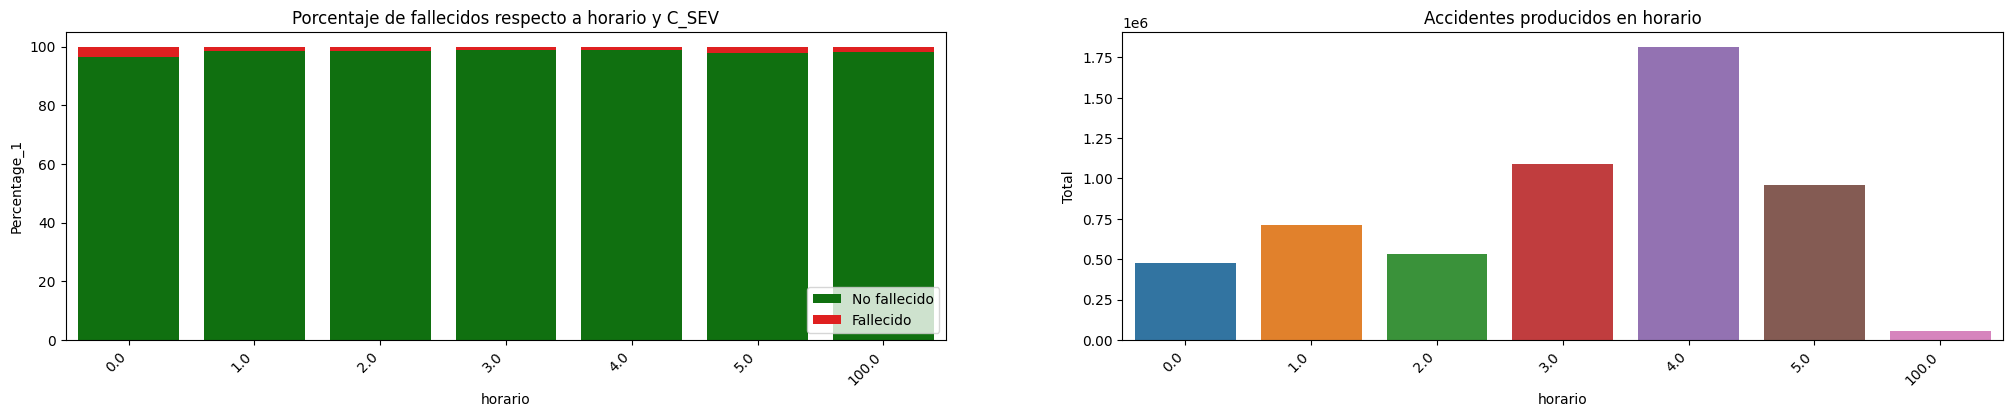

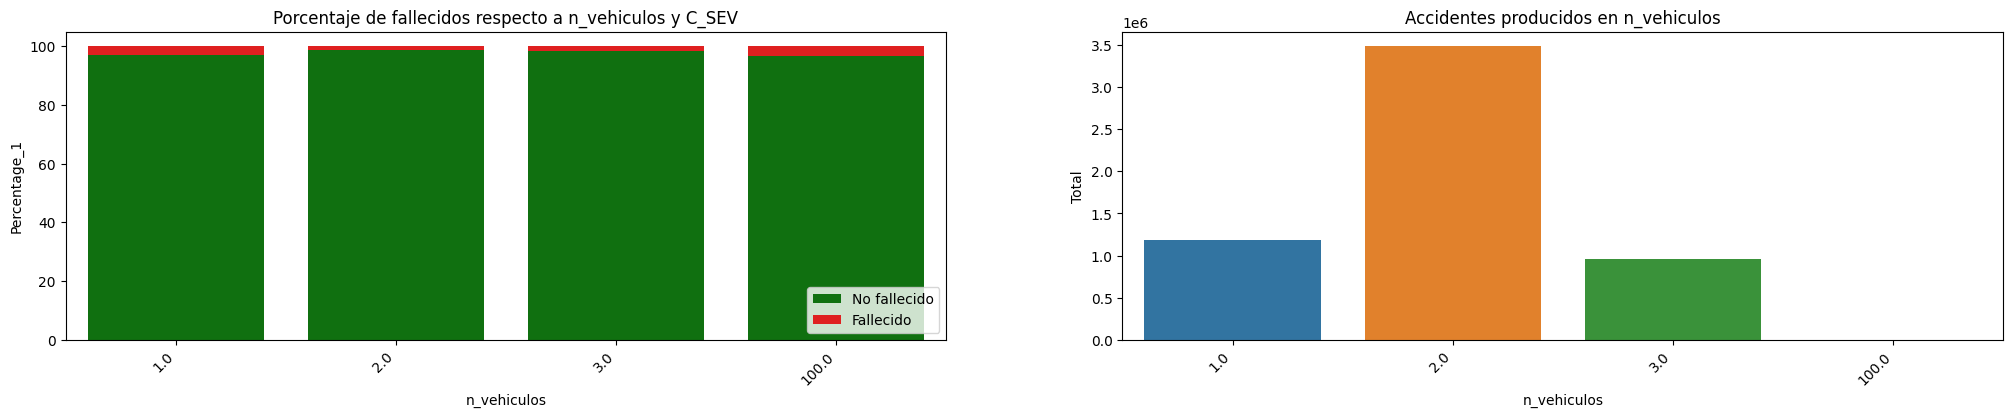

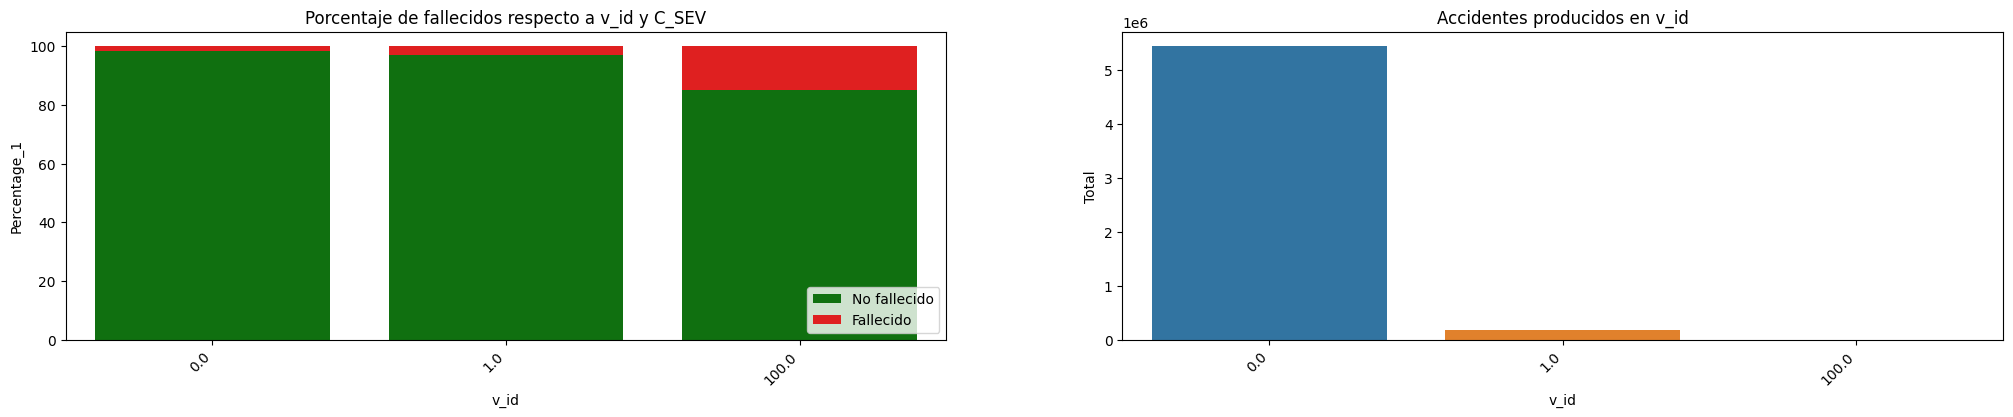

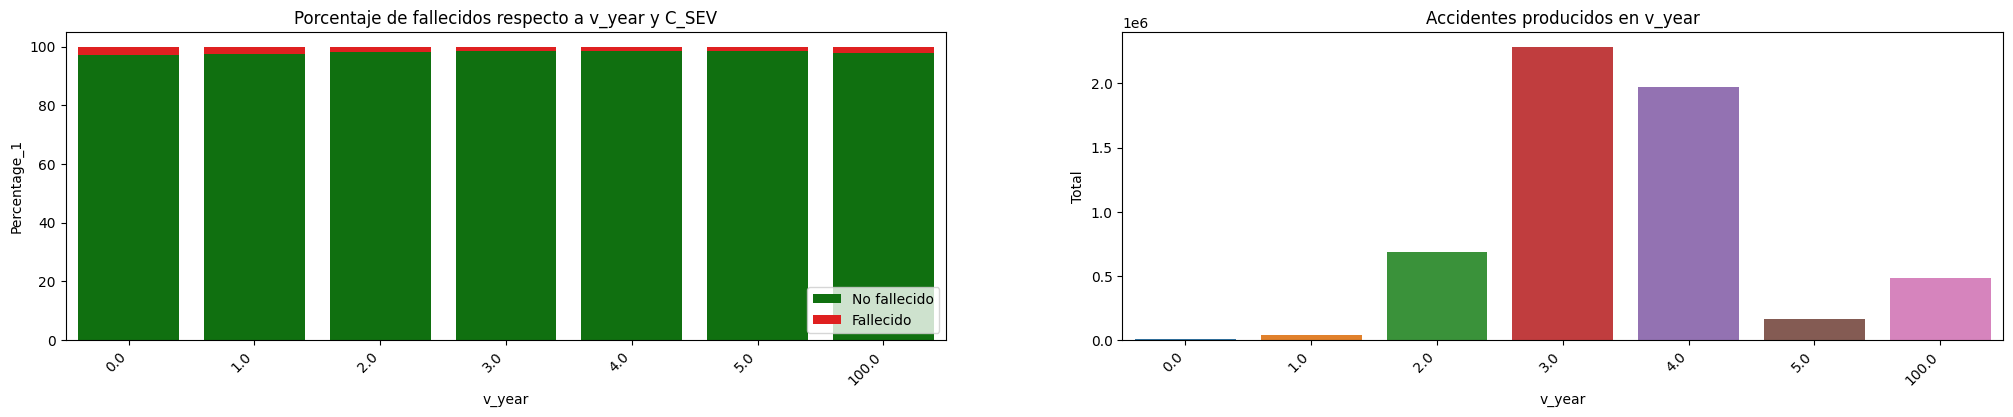

In [17]:
plot_things()

Vamos a comentar los datos más relevantes de estas gráficas.

1. Afortunadamente, tras el paso de los años parece reducirse el número de accidentes en Canadá.
2. La mayoría de los accidentes se producen o bien por un choque de las ruedas traseras o por el choque del lateral de un coche con el otro, aunque vemos que los más mortales son aquellos que tienen una colisión de frente, lo que tiene sentido ya que es la zona de impacto más cercana al conductor.
3. El clima que más afecta a la vida de los conductores es aquel en el que hay una visibilidad limitada o hay fuertes vientos.
4. El tipo de carretera que es más propensa a tener accidentes mortales es aquella que tiene pendiente.
5. Donde más accidentes mortales se producen son en los cruces de vías de tren en los que solo hay señales.
6. Para caso de negocio, los tipos de vehículos que son más propensos a sufrir un accidente mortal es un tractor y una moto de nieve (curioso, ya que en Canadá suele nevar).
7. Los datos nos confirman que si te encuentras sentado en el regazo de alguien(en principio sin cinturón), es más probable que sufras un accidente mortal, esto nos indica la importancia de la seguridad vial. Al igual que si noutilizas ningún dispositivo de seguridad, es más probable que sufras un  accidente mortal. Por suerte, la gran mayoría de los accidentes suceden con algún dispositivo de seguridad.
8. En general, cuanto más antiguo es el modelo del vehículo, más propenso es que sufra un accidente mortal. Aunque los datos que disponemos, la mayoría de los vehículos fueron fabricados entre 1990 y 2010.
9. Vemos que si no podemos identificar el vehículo en el que se encontraba una persona hay una tasa de muerte muy elevada, y en porcentaje es la más elevada de todo el conjunto de datos.


## 1.3 Correlación

En este caso no poseemos ni un orden ni variables numéricas, por lo que para calcular la correlación utilizaremos la V de Cramer, que funciona para este tipo de variables categóricas no ordinales.

In [18]:
from scipy.stats import chi2_contingency

In [19]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [20]:
df_min = df.sample(frac = 0.05) #Alto coste computacional, reducimos dataset

In [21]:
rows= []

for var1 in df_min:
  col = []
  for var2 in df_min:
    cramers =cramers_V(df_min[var1], df_min[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
matriz = pd.DataFrame(cramers_results, columns = df_min.columns, index =df_min.columns)

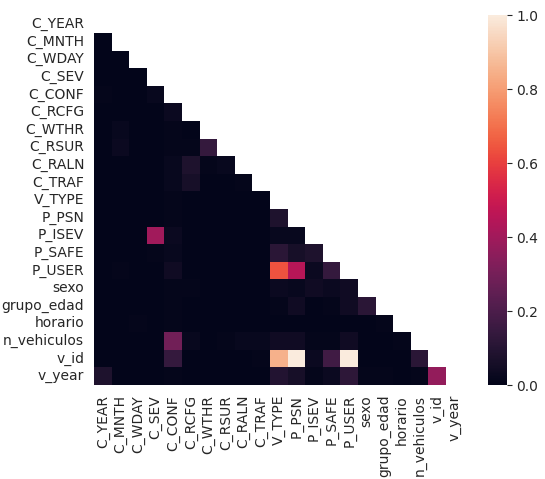

In [22]:
mask = np.zeros_like(matriz, dtype=bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(matriz, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

La única relación alta de correlación parece ser entre el tipo de vehículo y el `P_USER` que indica que vehículo llevaba la persona de forma más genérica (coche, moto, bicicleta, etc). Al haber una alta correlación entre ambas vamos a prescindir de `P_USER` que aporta menos información

In [23]:
df.drop(['P_USER'], axis = 1, inplace = True)

# 2. Modelado

In [24]:
from sklearn.model_selection import train_test_split

Separamos las variables en el conjunto de datos de entrenamiento y el conjunto de la variable a predecir, `y`.

In [25]:
df_reduced = df.sample(frac = .2, random_state=1) # Para reducir el coste computacional

X, y, y_2 = df_reduced.drop(['C_SEV', 'P_ISEV'], axis = 1), df_reduced['C_SEV'], df_reduced['P_ISEV']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

En este caso, vamos a utilizar algoritmos de arboles para elaborarel modelo, otras técnicas como KNN no tendrían sentido al serlo números no ordinales, y los mejores algoritmos son aquellos de árboles de decisión. 

## 2.1 Decission Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [28]:
%%time 

dt_clf = DecisionTreeClassifier(random_state=42)

def f1_class1(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 1, average='binary', pos_label=1)

scorer = make_scorer(f1_class1, greater_is_better=True)

param_grid = {
        'max_depth': [5, 10, 15, 20, 30, 50, None],
        'criterion': ['gini', 'entropy'],
    }

dt_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid,
                                n_iter=5, cv=3, scoring = scorer)

dt_search.fit(X_train, y_train)

CPU times: total: 1min 12s
Wall time: 1min 47s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 30, 50,
                                                      None]},
                   scoring=make_scorer(f1_class1))

In [29]:
dt_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    221605
           1       0.13      0.17      0.15      3776

    accuracy                           0.97    225381
   macro avg       0.56      0.57      0.56    225381
weighted avg       0.97      0.97      0.97    225381



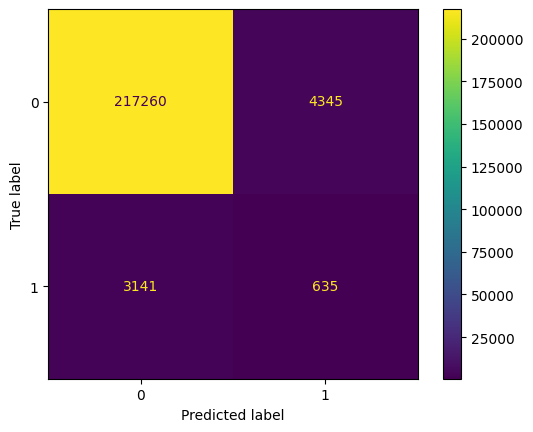

In [30]:
y_pred = dt_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [31]:
feature_importances = {name: score for name, score in zip(list(X), dt_search.best_estimator_.feature_importances_)}

In [32]:
feature_importances = pd.Series(feature_importances).sort_values(ascending=False)

In [33]:
feature_importances

C_YEAR         0.140093
C_MNTH         0.117588
C_CONF         0.108611
C_WDAY         0.093589
horario        0.073205
grupo_edad     0.060221
P_SAFE         0.050081
C_RALN         0.048689
v_year         0.048523
C_WTHR         0.040684
C_TRAF         0.037085
P_PSN          0.036214
V_TYPE         0.035792
C_RSUR         0.033079
C_RCFG         0.032565
sexo           0.022422
n_vehiculos    0.020836
v_id           0.000722
dtype: float64

Vamos a escoger las diez primeras variables, hasta `P_PSN`, que por el análisis realizado anteriormente sabemos que son más influyentes a la hora de determinar si ha habido fallecidos. Por ello procederemos a elaborar el mismo modelo con menos variables y más iteraciones.

In [34]:
columnas = feature_importances.index.to_list()[:10]
X_train_r, X_test_r = X_train[columnas], X_test[columnas]

In [35]:
dt_search_r = RandomizedSearchCV(dt_clf, param_distributions=param_grid,
                                n_iter=10, cv=5, scoring = scorer)

dt_search_r.fit(X_train_r, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 30, 50,
                                                      None]},
                   scoring=make_scorer(f1_class1))

In [36]:
dt_search_r.best_estimator_

DecisionTreeClassifier(criterion='entropy', random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    221605
           1       0.15      0.18      0.17      3776

    accuracy                           0.97    225381
   macro avg       0.57      0.58      0.58    225381
weighted avg       0.97      0.97      0.97    225381



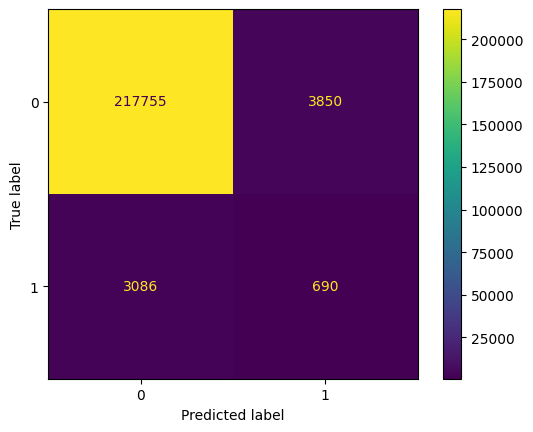

In [37]:
y_pred_r = dt_search_r.best_estimator_.predict(X_test_r)
print(classification_report(y_test, y_pred_r))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_r);

Observamos que los resultados no mejoran, pero el rendimiento computacional mejora. Podríamos probar con técnicas de desbalanceamiento como undersampling (oversampling en este caso no es muy recomendado, ya que los números soncódigos, no distancias).

## 2.2 LightGBM

En este caso nos vamos a decantar por un LightGBM ya que es un algoritmo muy potente y computacionalmente menos costoso que un RandomForest o un XGBoost.  

In [38]:
import lightgbm as lgb 

In [39]:
light = lgb.LGBMClassifier(n_estimators=100, objective = 'binary', is_unbalance=True, random_state=42, n_jobs = -1)

param_grid = {
        'max_depth': [5, 10, 15, 20, 30, 50, None],
        'boosting_type': ['gbdt', 'dart'],
        'learning_rate': [0.01, 0.1, 0.3]
    }

lgb_search = RandomizedSearchCV(light, param_distributions=param_grid,
                                n_iter=5, cv=3, scoring = 'balanced_accuracy')

lgb_search.fit(X_train_r, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=42),
                   n_iter=5,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20, 30, 50,
                                                      None]},
                   scoring='balanced_accuracy')

In [40]:
lgb_search.best_estimator_

LGBMClassifier(is_unbalance=True, learning_rate=0.3, max_depth=15,
               objective='binary', random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    221605
           1       0.04      0.61      0.07      3776

    accuracy                           0.71    225381
   macro avg       0.51      0.66      0.45    225381
weighted avg       0.97      0.71      0.82    225381



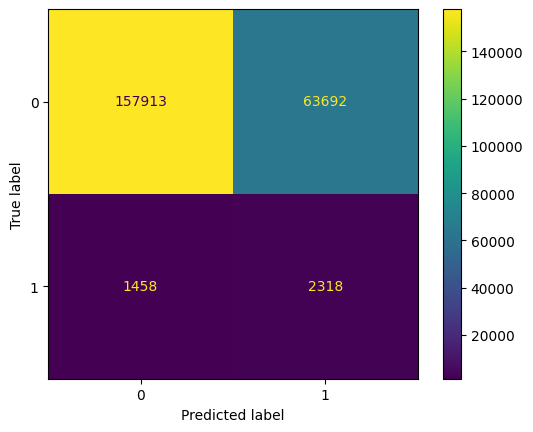

In [41]:
y_pred_l = lgb_search.best_estimator_.predict(X_test_r)
print(classification_report(y_test, y_pred_l))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_l);

Vemos como nuestro modelo mejora si le cambiamos la métrica, dado que nos baja mucho la precisión, vamos a utilizar como métrica la f2, para dar más importancia al recall(prefiero decir que una persona fallece y que no sea así que al revés), pero sin ignorar la precisión.

In [42]:
def f2_class1(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 2, average='binary', pos_label=1)

scorer = make_scorer(f2_class1, greater_is_better=True)

lgb_search = RandomizedSearchCV(light, param_distributions=param_grid,
                                n_iter=5, cv=3, scoring = scorer)

lgb_search.fit(X_train_r, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=42),
                   n_iter=5,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20, 30, 50,
                                                      None]},
                   scoring=make_scorer(f2_class1))

In [43]:
lgb_search.best_estimator_

LGBMClassifier(is_unbalance=True, learning_rate=0.01, max_depth=None,
               objective='binary', random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    221605
           1       0.11      0.37      0.16      3776

    accuracy                           0.94    225381
   macro avg       0.55      0.66      0.57    225381
weighted avg       0.97      0.94      0.95    225381



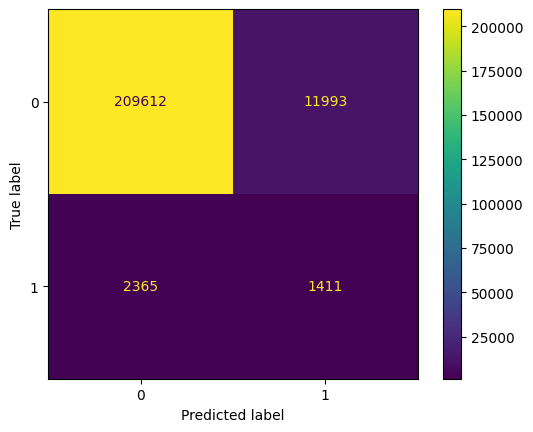

In [44]:
y_pred_l = lgb_search.best_estimator_.predict(X_test_r)
print(classification_report(y_test, y_pred_l))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_l);

Se queda exactamente igual. Ahora elaboraremos un modelo teniendo en cuenta los heridos.

## 2.3 Con heridos

In [45]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y_2, test_size=0.2, random_state=0)
X_2_r, X_r = X_train_2[columnas], X_test_2[columnas]

In [47]:
def f2_class1(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 1, average='macro', pos_label=1)

scorer = make_scorer(f2_class1, greater_is_better=True)

lgb_search_2 = RandomizedSearchCV(light, param_distributions=param_grid,
                                n_iter=5, cv=3, scoring = scorer)

lgb_search_2.fit(X_2_r, y_train_2)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=42),
                   n_iter=5,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20, 30, 50,
                                                      None]},
                   scoring=make_scorer(f2_class1))

In [48]:
lgb_search_2.best_estimator_

LGBMClassifier(boosting_type='dart', is_unbalance=True, learning_rate=0.3,
               max_depth=10, objective='binary', random_state=42)

              precision    recall  f1-score   support

         1.0       0.58      0.41      0.48     93280
         2.0       0.64      0.80      0.71    120797
         3.0       0.00      0.00      0.00      1570
       100.0       0.58      0.47      0.52      9734

    accuracy                           0.62    225381
   macro avg       0.45      0.42      0.43    225381
weighted avg       0.61      0.62      0.60    225381



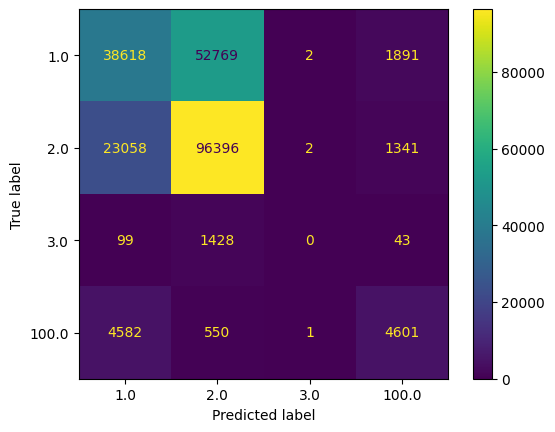

In [49]:
y_pred_2 = lgb_search_2.best_estimator_.predict(X_r)
print(classification_report(y_test_2, y_pred_2))
ConfusionMatrixDisplay.from_predictions(y_test_2, y_pred_2);

Observamos que a la hora de predecir, para los valores desconocidos, los no heridos y los heridos predice de forma decente, mientras que para identificar a los fallecidos no acierta ninguno, esto se debe a que disponemos de muchos menos datos para dicha categoría que para el resto.

##  Conclusiones

Como hemos visto, el dataset al que nos enfrentábamos era complicado. Hemos intentado sacar diferentes conclusiones, tales como cuáles son los factores que más influyen en los accidentes para que sean mortales. Posteriormente hemos intentado elaborar dos modelos, uno que diferencie entre muerte y no muerte, mientras que el otro para diferenciar entre no herido, herido y fallecido(factor importante para que las aseguradoras determinen el precio de los seguros). Aunque los modelos no devuelvan resultados muy satisfactorios(en gran parte debido a que el dataset eran códigos y no uno numérico o con variables categóricas u ordinales), se ha podido determinar que tipos de vehículos son más propensos a tener accidentes mortales, en que meteorología o ver que hay otros factores que no son determinantes tales como el sexo. Como futuras ideas se podría buscar el color del coche(al menos en España es determinante el color) y otro tipo de factores que eran imposibles de determinar aquí. 

Con esto ponemos el fin al trabajo y a la asignatura de Machine Learning, ¡espero que disfrutes tanto este trabajo como yo he disfrutado la asignatura!